**Notebook to generate USGS mean irrigation ratio dataset**

USGS ratio = mean of GW/total irrigation

Steps:
- Load HUC-X level USGS GW and total irrigation monthly dataset from 2000 to 2020
- Calculate yearly totals
- Calculate GW/total irrigation for each HUC for each time unit (year)
- Calculate mean GW/total irrigation for each HUC (mean of all years)
- Load HUC-X shapefiles and merge mean GW/total irrigation with the shapefiles
- Convert the vector dataset to a raster.
- Fill missing cells with missing value (0 or -1 or -99 or NaN)
- Compare with FFelfelani's old USGS county-based raster.

Preparing dataset for the entire CONUS.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import netCDF4 as nc
import xarray as xr
import dask
import rasterio
import rioxarray
from rasterio.plot import show
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from rasterio.features import geometry_mask
from mpl_toolkits.basemap import Basemap, maskoceans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib as mpl
import hydroeval

In [2]:
import sys

# Import my own library
sys.path.insert(0, str("/glade/u/home/amans/tools/amanspylib/nclib"))
import ncplotter

In [3]:
import warnings

warnings.filterwarnings("ignore")

# Read files

In [4]:
# this is mach specific. need to change
DIR_TO_DATA = r"/glade/work/amans/data_mizu/"
ARCHIVE_DIR = r"/glade/derecho/scratch/amans/archive/"

In [5]:
# ncpath1 = ARCHIVE_DIR + CASENAME1 + "/lnd/hist"
# ncpath2 = (
#     ARCHIVE_DIR + CASENAME2 + "/lnd/hist"
# )  # CASENAME2 is 0.5 deg 1980-2020 simulations. Use climate variables for plot
# ncpath_0125 = "/glade/campaign/univ/umsu0016/ENE828/F002-I2000Clm50BgcCrop_nldas/lnd/hist"
# SURF_PATH_005 = r"/glade/work/amans/data/MRB-CONUS_0.05/surfdata_0.05-conus_irrigation_hist_2000_78pfts_MRB_0.05_c240506.nc"
# SURF_PATH_0125 = r"/glade/work/amans/data/MRB-CONUS_0.125/surfdata_0.125-global_hist_2000_78pfts_nldas_0.125_irrigation_c240618.nc"
# parampath = r"/glade/u/home/amans/Crop_CLM/ctsm51_params.c240105_7.nc"
plotpath = os.path.join(os.getcwd(), "plots")
shpPATH = DIR_TO_DATA + "Shapefiles"
datapath = (
    DIR_TO_DATA + r"USGS_water_use/modified_monthly_crop_irrigation_withdrawal"
)
ncplotter.ensure_directory_exists(plotpath)

Directory '/glade/work/amans/Analysis/USGS_mean_dataset/250516_creating_USGS_mean/plots' already exists.


True

### Read shapefiles to plot

Read MRB, HPA, US_states, and county shps.

In [6]:
print("Reading MRB shapefile...")
mrb = gpd.read_file(
    os.path.join(shpPATH, "merged_MRB_HPA", "MRB-HPA_espg3857.shp")
)
mrb.to_crs(epsg=4326, inplace=True)

print("Reading HPA shapefile.")
hpa = gpd.read_file(os.path.join(shpPATH, "HPA_espg4326.shp"))

# Reading huc2 shapefiles
print("Reading HUC2 shapefile...")
huc2_mrb = gpd.read_file(os.path.join(shpPATH, "HUC_2", "HUC-2_in_MRB.shp"))
huc2_mrb.to_crs(epsg=4326, inplace=True)

print("Reading Great Lakes shapefile")
grl = gpd.read_file(os.path.join(shpPATH, "Great_Lakes", "GL240425_lam.shp"))
grl.to_crs(epsg=4326, inplace=True)

print("Reading Mississippi Alluvial Plains shapefile")
map = gpd.read_file(
    os.path.join(
        shpPATH, "MAP_generalized_regions", "MAP_generalized_regions.shp"
    )
)
map.to_crs(epsg=4326, inplace=True)

print("Reading US states")
US_states = gpd.read_file(
    os.path.join(shpPATH, "US_states", "cb_2018_us_state_500k.shp")
)
print("Reading US counties")
US_counties = gpd.read_file(
    os.path.join(shpPATH, "US_counties", "cb_2018_us_county_20m.shp")
)
US_counties.crs

Reading MRB shapefile...
Reading HPA shapefile.
Reading HUC2 shapefile...
Reading Great Lakes shapefile
Reading Mississippi Alluvial Plains shapefile
Reading US states
Reading US counties


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [7]:
%%time
HUC_LEVEL = 8
huc_n = "huc" + str(HUC_LEVEL)

if HUC_LEVEL == 6:
    print("Reading HUC6 shapefile.")
    # Only contains HUC6s within MRB bounds
    huc = gpd.read_file(os.path.join(shpPATH, 'HUC_6','HUC_6.shp'))
    huc.to_crs(epsg=4326, inplace=True) # Convert to epsg4326
elif HUC_LEVEL == 8:
    # Read HUC8s in MRB

    # This is loading ~300MB so will slow the processes. Takes around ~30 secs.
    print("Reading HUC8s shapefile.")
    huc = gpd.read_file(
        os.path.join(shpPATH, "HUC8", "HUC_8.shp")
    )
    huc.to_crs(epsg=4326, inplace=True)
else:
    raise ValueError('HUC_LEVEL other than 6 or 8 not supported yet.')

Reading HUC8s shapefile.
CPU times: user 40.2 s, sys: 727 ms, total: 40.9 s
Wall time: 41 s


## Read USGS data

## Read csv

In [8]:
# Read long format data (aggregated)
# Unit is Million gal/day
gw = pd.read_csv(os.path.join(datapath, f"IR_{huc_n.upper()}_GW_2000_2020.csv"))
# sw = pd.read_csv(os.path.join(datapath, f"IR_{huc_n.upper()}_SW_2000_2020.csv"))
tot = pd.read_csv(os.path.join(datapath, f"IR_{huc_n.upper()}_Tot_2000_2020.csv"))

# Convert million gals to million m3/day
gw["irrigation"] = gw["irrigation"] / 264.2
# sw["irrigation"] = sw["irrigation"] / 264.2
tot["irrigation"] = tot["irrigation"] / 264.2

In [9]:
USGS_dates = pd.date_range(date(2000, 1, 1), date(2020, 12, 1), freq="MS")
USGS_dates.shape

(252,)

In [10]:
# Convert int HUC number to string with six digits
# sw[huc_n.upper()] = [f"{int(x):0{HUC_LEVEL}d}" for x in sw[huc_n.upper()]]
gw[huc_n.upper()] = [f"{int(x):0{HUC_LEVEL}d}" for x in gw[huc_n.upper()]]
tot[huc_n.upper()] = [f"{int(x):0{HUC_LEVEL}d}" for x in tot[huc_n.upper()]]

tot.head()

,Year,Month,HUC8,irrigation
0,2000,1,01010002,0.0
1,2000,1,01010003,0.0
2,2000,1,01010004,0.0
3,2000,1,01010005,0.0
4,2000,1,01010006,0.0


In [11]:
%%time
# Multiply by days of months to get monthly total
days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# sw['irrigation_per_month'] = sw.apply(lambda row: row['irrigation'] * days_in_month[row['Month']-1], axis=1)
gw['irrigation_per_month'] = gw.apply(lambda row: row['irrigation'] * days_in_month[row['Month']-1], axis=1)
tot['irrigation_per_month'] = tot.apply(lambda row: row['irrigation'] * days_in_month[row['Month']-1], axis=1)

CPU times: user 7.22 s, sys: 92.1 ms, total: 7.32 s
Wall time: 7.32 s


# Calculate annual totals

In [12]:
gw_annual = gw.groupby(['Year', huc_n.upper()]).agg({'irrigation_per_month': 'sum'}).reset_index()
gw_annual = gw_annual.rename(columns={'irrigation_per_month': 'irrigation_per_year'})

tot_annual = tot.groupby(['Year', huc_n.upper()]).agg({'irrigation_per_month': 'sum'}).reset_index()
tot_annual = tot_annual.rename(columns={'irrigation_per_month': 'irrigation_per_year'})

# Calculate GW/total ratio

In [13]:
# Merge gw and tot dataframes
irrig_ratio_df = gw_annual.merge(tot_annual, on=['Year', huc_n.upper()], how='inner')

# Calculate GW/total ratio
irrig_ratio_df['irrigation_ratio'] = irrig_ratio_df['irrigation_per_year_x'] / irrig_ratio_df['irrigation_per_year_y']

In [14]:
assert sum(irrig_ratio_df['irrigation_ratio'] > 1) == 0, "GW/Total ratio > 1. Check the data."
assert sum(irrig_ratio_df['irrigation_ratio'] < 0) == 0, "GW/Total ratio < 0. Check the data."

# Calculate mean GW/total irrigation for each HUC (mean of all years)

In [15]:
mean_irrig_ratio = irrig_ratio_df.groupby(huc_n.upper()).agg({'irrigation_ratio': 'mean'}).reset_index()

In [16]:
# Check if all HUCs are present
assert len(mean_irrig_ratio) == len(irrig_ratio_df[huc_n.upper()].unique())
print('OK: All HUCs are present in the mean irrigation ratio dataframe.')

OK: All HUCs are present in the mean irrigation ratio dataframe.


In [17]:
mean_irrig_ratio.head()

,HUC8,irrigation_ratio
0,01010002,NaN
1,01010003,0.100002
2,01010004,0.100000
3,01010005,0.100004
4,01010006,NaN


In [18]:
# Drop rows with NaN
mean_irrig_ratio = mean_irrig_ratio.dropna()

In [19]:
assert sum(mean_irrig_ratio['irrigation_ratio'].isna()) == 0, 'NaN values are present.'

# Merge shapefiles with df

In [20]:
%%time
mean_irrig_ratio_gdf = huc.merge(
    mean_irrig_ratio, left_on=[huc_n], right_on=[huc_n.upper()], how='inner',
)

CPU times: user 3.15 ms, sys: 128 µs, total: 3.28 ms
Wall time: 3 ms


In [21]:
len(mean_irrig_ratio), len(mean_irrig_ratio_gdf)

(1770, 1769)

In [22]:
assert len(mean_irrig_ratio) == len(mean_irrig_ratio_gdf), "Number of rows in mean irrigation ratio and HUC shapefile do not match. Check the data."

AssertionError: Number of rows in mean irrigation ratio and HUC shapefile do not match. Check the data.

<Axes: >

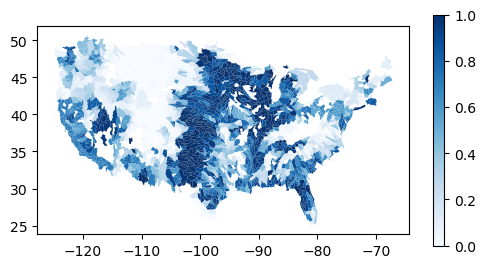

In [23]:
mean_irrig_ratio_gdf.plot(column='irrigation_ratio', cmap='Blues', legend=True, figsize=(6,3))

# Convert vector to raster.

## Rasterize

In [24]:
bounds = mean_irrig_ratio_gdf.total_bounds
bounds

array([-124.90221994,   25.10390462,  -67.12821001,   50.63472293])

In [25]:
# Verify the CRS
print(f"GeoDataFrame CRS: {mean_irrig_ratio_gdf.crs}")
if mean_irrig_ratio_gdf.crs.to_epsg() != 4326:
    raise ValueError("Warning: GeoDataFrame is not in EPSG:4326. The following steps assume this CRS.")

# --- Rasterize directly in EPSG:4326 (resolution in degrees) ---
resolution = 0.05

GeoDataFrame CRS: EPSG:4326


In [27]:
if resolution == 0.5:
    # at 0.5 deg
    desired_extent = [-126, 24, -65, 53.5]  # [minx, miny, maxx, maxy]
elif resolution == 0.05:
    desired_extent = [-126, 24, -65, 53.5]
else:
    raise ValueError('Invalid resolution')

minx, miny, maxx, maxy = desired_extent

In [28]:
width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)
affine = rasterio.Affine(resolution, 0, minx, 0, resolution, miny)

raster = np.zeros((height, width), dtype=np.float32)
shapes = ((geom, value) for geom, value in zip(mean_irrig_ratio_gdf.geometry, mean_irrig_ratio_gdf['irrigation_ratio']))

rasterized = rasterio.features.rasterize(shapes=shapes,
                                 out=raster,
                                 transform=affine,
                                 fill=0,
                                 all_touched=False,
                                 dtype=np.float32)



## Convert to xarray dataarray

In [29]:
%%time
# --- Create coordinate arrays for actual latitude and longitude ---
actual_longitude = np.linspace(minx + resolution / 2, maxx - resolution / 2, width)
actual_latitude = np.linspace(miny + resolution / 2, maxy - resolution / 2, height)

# --- Create the xarray DataArray ---
raster_xr = xr.DataArray(
    rasterized,
    coords={
        "lsmlat": np.arange(height),
        "lsmlon": np.arange(width),
    },
    dims=("lsmlat", "lsmlon"),
    name="USGS_mean"
)

# Add actual latitude and longitude as data variables
raster_xr['lat'] = (('lsmlat',), actual_latitude)
raster_xr['lon'] = (('lsmlon',), actual_longitude)

# Set the CRS using rioxarray's set_crs
raster_xr = raster_xr.rio.set_crs(mean_irrig_ratio_gdf.crs)
# Change FillValue to 0.0 instead of NaN
# raster_xr.attrs['_FillValue'] = np.float32(0.0)

CPU times: user 45.1 ms, sys: 20 ms, total: 65.1 ms
Wall time: 654 ms


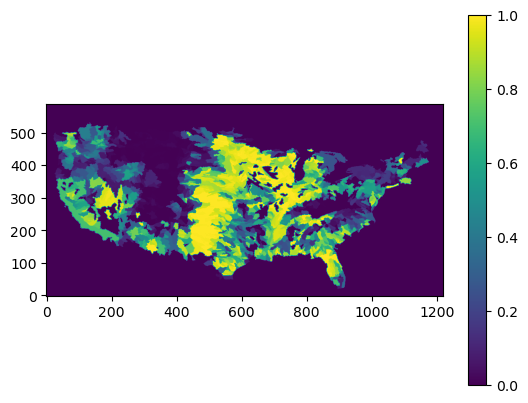

In [30]:
plt.imshow(raster_xr, origin='lower')
plt.colorbar()

In [31]:
output_raster_path = os.path.join(os.getcwd(), f'USGS_mean_irrig_ratio_{huc_n.upper()}_{str(resolution)}_c{date.today().strftime('%y%m%d')}.nc')

raster_xr.to_netcdf(output_raster_path, mode='w', format='NETCDF4')

print(f"Rasterized mean irrigation ratio (in EPSG:4326) saved to: {output_raster_path}")

Rasterized mean irrigation ratio (in EPSG:4326) saved to: /glade/work/amans/Analysis/USGS_mean_dataset/250516_creating_USGS_mean/USGS_mean_irrig_ratio_HUC8_0.05_c250517.nc


# Read the output raster for check

In [ ]:
ds1 =xr.open_dataset(output_raster_path)
ds1

In [ ]:
plt.imshow(ds1['mean_irrigation_ratio'], origin='lower')

In [ ]:
ds2 = xr.open_dataset('/glade/work/amans/data/MRB-CONUS_0.5/merged_ctsm5.3_and_5.2_fsurf/surfdata_48x77-MRB_0.5_hist_1979_78pfts_YiYao_USGS_ratio_c250515.nc')

In [ ]:
plt.imshow(ds2['USGS_mean'])


- Compare with FFelfelani's old USGS county-based raster.